In [1]:
import pandas as pd # to read CSV files (Comma Separated Values)

train_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.x.csv')
train_x.head()

,Id,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att18,att19,att20,att21,att22,att23,att24,att25,att26,msd_track_id
0,1,41.08,6.579,4.307,3.421,3.192,2.076,2.179,2.052,1.794,...,1.3470,-0.2463,-1.5470,0.17920,-1.1530,-0.7370,0.40750,-0.67190,-0.05147,TRPLTEM128F92E1389
1,2,60.80,5.973,4.344,3.261,2.835,2.725,2.446,1.884,1.962,...,-0.3316,0.3519,-1.4760,0.52700,-2.1960,1.5990,-1.39000,0.22560,-0.72080,TRJWMBQ128F424155E
2,3,51.47,4.971,4.316,2.916,3.112,2.290,2.053,1.934,1.878,...,-0.2803,-0.1603,-0.1355,1.03500,0.2370,1.4890,0.02959,-0.13670,0.10820,TRRZWMO12903CCFCC2
3,4,41.28,6.610,4.411,2.602,2.822,2.126,1.984,1.973,1.945,...,-1.6930,1.0040,-0.3953,0.26710,-1.0450,0.4974,0.03724,1.04500,-0.20000,TRBZRUT12903CE6C04
4,5,54.17,8.945,4.685,4.208,3.154,3.527,2.733,2.202,2.686,...,2.4690,-0.5449,-0.5622,-0.08968,-0.9823,-0.2445,-1.65800,-0.04825,-0.70950,TRLUJQF128F42AF5BF


In [2]:
train_y = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.y.csv')
train_y.head()

,Id,class_label
0,1,International
1,2,Vocal
2,3,Latin
3,4,Blues
4,5,Vocal


In [3]:
test_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/test.x.csv')
test_x.head()

,Id,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att17,att18,att19,att20,att21,att22,att23,att24,att25,att26
0,1,38.22,8.076,6.935,4.696,3.856,3.465,2.922,2.568,2.070,...,3.988,0.4957,0.1836,-2.2210,0.6453,-0.2923,1.2000,-0.09179,0.4674,0.2158
1,2,36.42,6.131,5.364,4.292,3.968,2.937,2.872,2.142,2.050,...,7.098,1.2290,0.5971,-1.0670,0.9569,-1.8240,2.3130,-0.80890,0.5612,-0.6225
2,3,70.01,5.496,4.698,3.699,3.258,2.293,2.680,2.226,2.034,...,4.449,0.4773,1.6370,-1.0690,2.4160,-0.6299,1.4190,-0.81960,0.9151,-0.5948
3,4,40.64,7.281,6.702,4.043,3.729,3.043,2.644,2.366,1.940,...,2.785,1.9000,-1.1370,1.2750,1.7920,-2.1250,1.6090,-0.83230,-0.1998,-0.1218
4,5,38.85,7.118,5.703,4.825,4.088,3.823,3.254,2.551,2.193,...,4.536,2.1470,1.0200,-0.2656,2.8050,0.2762,0.2504,1.04900,0.3447,-0.7689


In [4]:
test_y_sample = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/submission-random.csv')
test_y_sample.head()

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.0964,0.0884,0.0121,0.1004,0.0137,0.1214,0.0883,0.0765,0.0332,0.0445,0.1193,0.1019,0.1038
1,2,0.0121,0.0804,0.0376,0.0289,0.1310,0.0684,0.1044,0.0118,0.1562,0.0585,0.1633,0.1400,0.0073
2,3,0.1291,0.0985,0.0691,0.0356,0.0788,0.0529,0.1185,0.1057,0.1041,0.0075,0.0481,0.1283,0.0238
3,4,0.0453,0.1234,0.0931,0.0126,0.1224,0.0627,0.0269,0.0764,0.0812,0.1337,0.0357,0.0937,0.0930
4,5,0.0600,0.0915,0.0667,0.0947,0.0509,0.0335,0.1251,0.0202,0.1012,0.0365,0.1310,0.0898,0.0991


In [5]:
test_y_sample[:0]

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal


In [6]:
import numpy as np

train_X = np.array(train_x)
train_Y = np.array(train_y[:]['class_label'])
test_X = np.array(test_x)

# Getting rid of the first and the last column: Id and msd_track_id
X_train_val = np.array(train_X[:, 1:-1], dtype=float)
X_test = np.array(test_X[:, 1:], dtype=float)

train_Y.shape

(13000,)

In [7]:
from collections import Counter

# Count the freq of the keys in the training labels
counted_labels = Counter(train_Y)
labels_keys = counted_labels.keys()
labels_keys

dict_keys(['Country', 'Vocal', 'Electronic', 'Folk', 'Pop_Rock', 'RnB', 'Jazz', 'Rap', 'Reggae', 'International', 'New_Age', 'Blues', 'Latin'])

In [8]:
labels_keys_sorted = sorted(labels_keys)
labels_keys_sorted

['Blues',
 'Country',
 'Electronic',
 'Folk',
 'International',
 'Jazz',
 'Latin',
 'New_Age',
 'Pop_Rock',
 'Rap',
 'Reggae',
 'RnB',
 'Vocal']

In [9]:
# This for loop for creating a dictionary/ vocab
key_to_val = {key: val for val, key in enumerate(labels_keys_sorted)}
key_to_val['Country']
key_to_val

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'International': 4,
 'Jazz': 5,
 'Latin': 6,
 'New_Age': 7,
 'Pop_Rock': 8,
 'Rap': 9,
 'Reggae': 10,
 'RnB': 11,
 'Vocal': 12}

In [10]:
val_to_key = {val: key for val, key in enumerate(labels_keys_sorted)}
val_to_key[1]
val_to_key

{0: 'Blues',
 1: 'Country',
 2: 'Electronic',
 3: 'Folk',
 4: 'International',
 5: 'Jazz',
 6: 'Latin',
 7: 'New_Age',
 8: 'Pop_Rock',
 9: 'Rap',
 10: 'Reggae',
 11: 'RnB',
 12: 'Vocal'}

In [11]:
Y_train_vec = []
for each in train_y[:]['class_label']:
#     print(each, key_to_val[each])
    Y_train_vec.append(key_to_val[each])

Y_train_val = np.array(Y_train_vec)
Y_train_val.shape

(13000,)

In [12]:
# # Pre-processing: normalizing
# def normalize(X):
#     # max scale for images 255= 2**8= 8 bit grayscale for each channel
#     return (X - X.mean(axis=0)) #/ X.std(axis=0)
# X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

# Preprocessing: normalizing the data based on the training set
mean = X_train_val.mean(axis=0)
std = X_train_val.std(axis=0)

X_train_val, X_test = (X_train_val - mean)/ std, (X_test - mean)/ std
X_train_val.shape, X_test.shape, X_train_val.dtype, X_test.dtype

((13000, 26), (10400, 26), dtype('float64'), dtype('float64'))

In [13]:
# Creating validation set: 10% or 1/10 of the training set or whatever dataset with labels/ annotation
valid_size = X_train_val.shape[0]//10
valid_size
X_val = X_train_val[-valid_size:]
Y_val = Y_train_val[-valid_size:]
X_train = X_train_val[: -valid_size]
Y_train = Y_train_val[: -valid_size]
X_train_val.shape, 
X_train.shape, X_val.shape, X_test.shape, Y_val.shape, Y_train.shape 
# X_train.dtype, X_val.dtype
# Y_train.dtype, Y_val

((11700, 26), (1300, 26), (10400, 26), (1300,), (11700,))

In [23]:
def softmax(X):
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def tanh_forward(X):
    out = np.tanh(X)
    cache = out
    return out, cache

def tanh_backward(dout, cache):
    # dX = dout * (1 - (np.tanh(X)**2)) # dTanh = 1-tanh**2
    dX = (1 - cache**2) * dout
    return dX

def cross_entropy(y_pred, y_train):
    m = y_pred.shape[0]

    prob = softmax(y_pred)
    log_like = -np.log(prob[range(m), y_train]) # to avoid the devision by zero
    data_loss = np.sum(log_like) / m

    return data_loss

def dcross_entropy(y_pred, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
    m = y_pred.shape[0]

    grad_y = softmax(y_pred)
    grad_y[range(m), y_train] -= 1.
    grad_y /= m

    return grad_y

In [24]:
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), 
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), 
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), 
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        dX = dout @ W.T # Backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = tanh_forward(X=y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append((fc_cache, nl_cache))
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        # Softmax is included in loss function
        if train:
            caches.append(fc_cache)

        return y, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        # dSoftmax is included in loss function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_prob = softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y, y_mini)
            grads = self.train_backward(dy, caches) 
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Trained model info
            y_pred, y_logit = self.test(X_mini)
            loss, _ = self.loss_function(y_logit, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validated model info
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter: {}, train loss: {:.4f}, train acc: {:.4f}, valid loss: {:.4f}, valid acc: {:.4f}'.format(
                    iter, loss, acc, valid_loss, valid_acc))

In [25]:
Y_train.shape, X_train.shape, X_val.shape, Y_val.shape

((11700,), (11700, 26), (1300, 26), (1300,))

In [42]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 128 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 64 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = Y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, Y_train), val_set=(X_val, Y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter: 10, train loss: 2.5950, train acc: 0.0703, valid loss: 2.5696, valid acc: 0.0838
Iter: 20, train loss: 2.5440, train acc: 0.1094, valid loss: 2.5577, valid acc: 0.0846
Iter: 30, train loss: 2.5453, train acc: 0.0625, valid loss: 2.5457, valid acc: 0.0900
Iter: 40, train loss: 2.4715, train acc: 0.1406, valid loss: 2.5354, valid acc: 0.1023
Iter: 50, train loss: 2.5392, train acc: 0.1016, valid loss: 2.5246, valid acc: 0.1108
Iter: 60, train loss: 2.4727, train acc: 0.1250, valid loss: 2.5140, valid acc: 0.1200
Iter: 70, train loss: 2.4657, train acc: 0.1562, valid loss: 2.5040, valid acc: 0.1292
Iter: 80, train loss: 2.4504, train acc: 0.1406, valid loss: 2.4949, valid acc: 0.1331
Iter: 90, train loss: 2.4782, train acc: 0.1328, valid loss: 2.4856, valid acc: 0.1408
Iter: 100, train loss: 2.4681, train acc: 0.1328, valid loss: 2.4761, valid acc: 0.1400
Iter: 110, train loss: 2.5000, train acc: 0.1328, valid loss: 2.4668, valid acc: 0.1523
Iter: 120, train loss: 2.4162, train acc:

Iter: 950, train loss: 2.1968, train acc: 0.3047, valid loss: 2.1478, valid acc: 0.2877
Iter: 960, train loss: 2.0881, train acc: 0.2969, valid loss: 2.1468, valid acc: 0.2854
Iter: 970, train loss: 2.0479, train acc: 0.3672, valid loss: 2.1451, valid acc: 0.2900
Iter: 980, train loss: 2.0189, train acc: 0.3438, valid loss: 2.1438, valid acc: 0.2900
Iter: 990, train loss: 2.1385, train acc: 0.2891, valid loss: 2.1421, valid acc: 0.2900
Iter: 1000, train loss: 2.0740, train acc: 0.3281, valid loss: 2.1409, valid acc: 0.2900
Iter: 1010, train loss: 2.0317, train acc: 0.3672, valid loss: 2.1394, valid acc: 0.2885
Iter: 1020, train loss: 1.9661, train acc: 0.4141, valid loss: 2.1382, valid acc: 0.2900
Iter: 1030, train loss: 2.0528, train acc: 0.3125, valid loss: 2.1370, valid acc: 0.2908
Iter: 1040, train loss: 2.0481, train acc: 0.2969, valid loss: 2.1358, valid acc: 0.2892
Iter: 1050, train loss: 2.0469, train acc: 0.3047, valid loss: 2.1349, valid acc: 0.2900
Iter: 1060, train loss: 2.

Iter: 1890, train loss: 1.9797, train acc: 0.3047, valid loss: 2.0715, valid acc: 0.3069
Iter: 1900, train loss: 2.0254, train acc: 0.3516, valid loss: 2.0710, valid acc: 0.3062
Iter: 1910, train loss: 2.2114, train acc: 0.2656, valid loss: 2.0705, valid acc: 0.3092
Iter: 1920, train loss: 2.1420, train acc: 0.3828, valid loss: 2.0699, valid acc: 0.3077
Iter: 1930, train loss: 2.0954, train acc: 0.3281, valid loss: 2.0695, valid acc: 0.3108
Iter: 1940, train loss: 1.9918, train acc: 0.3359, valid loss: 2.0694, valid acc: 0.3108
Iter: 1950, train loss: 1.9661, train acc: 0.3516, valid loss: 2.0689, valid acc: 0.3085
Iter: 1960, train loss: 2.0347, train acc: 0.3438, valid loss: 2.0683, valid acc: 0.3085
Iter: 1970, train loss: 2.0689, train acc: 0.2812, valid loss: 2.0674, valid acc: 0.3115
Iter: 1980, train loss: 2.0468, train acc: 0.3281, valid loss: 2.0671, valid acc: 0.3123
Iter: 1990, train loss: 1.9924, train acc: 0.3125, valid loss: 2.0664, valid acc: 0.3138
Iter: 2000, train los

Iter: 2830, train loss: 2.0316, train acc: 0.3203, valid loss: 2.0431, valid acc: 0.3192
Iter: 2840, train loss: 1.9050, train acc: 0.3281, valid loss: 2.0430, valid acc: 0.3192
Iter: 2850, train loss: 1.9992, train acc: 0.3438, valid loss: 2.0429, valid acc: 0.3200
Iter: 2860, train loss: 1.9447, train acc: 0.3828, valid loss: 2.0428, valid acc: 0.3169
Iter: 2870, train loss: 2.0187, train acc: 0.3438, valid loss: 2.0429, valid acc: 0.3177
Iter: 2880, train loss: 1.9718, train acc: 0.3438, valid loss: 2.0430, valid acc: 0.3231
Iter: 2890, train loss: 1.9394, train acc: 0.3672, valid loss: 2.0427, valid acc: 0.3238
Iter: 2900, train loss: 2.0316, train acc: 0.3047, valid loss: 2.0425, valid acc: 0.3231
Iter: 2910, train loss: 1.8815, train acc: 0.4453, valid loss: 2.0419, valid acc: 0.3246
Iter: 2920, train loss: 1.9530, train acc: 0.4297, valid loss: 2.0417, valid acc: 0.3246
Iter: 2930, train loss: 2.2642, train acc: 0.2656, valid loss: 2.0408, valid acc: 0.3238
Iter: 2940, train los

Iter: 3770, train loss: 1.9069, train acc: 0.3281, valid loss: 2.0307, valid acc: 0.3315
Iter: 3780, train loss: 1.9770, train acc: 0.3125, valid loss: 2.0305, valid acc: 0.3300
Iter: 3790, train loss: 1.9015, train acc: 0.4219, valid loss: 2.0305, valid acc: 0.3323
Iter: 3800, train loss: 1.8254, train acc: 0.4141, valid loss: 2.0304, valid acc: 0.3346
Iter: 3810, train loss: 1.9324, train acc: 0.4062, valid loss: 2.0311, valid acc: 0.3331
Iter: 3820, train loss: 2.0526, train acc: 0.3359, valid loss: 2.0314, valid acc: 0.3323
Iter: 3830, train loss: 1.9700, train acc: 0.3359, valid loss: 2.0312, valid acc: 0.3331
Iter: 3840, train loss: 1.9136, train acc: 0.3594, valid loss: 2.0310, valid acc: 0.3331
Iter: 3850, train loss: 1.9423, train acc: 0.3359, valid loss: 2.0312, valid acc: 0.3323
Iter: 3860, train loss: 1.8118, train acc: 0.3750, valid loss: 2.0311, valid acc: 0.3323
Iter: 3870, train loss: 1.8624, train acc: 0.3203, valid loss: 2.0314, valid acc: 0.3315
Iter: 3880, train los

Iter: 4710, train loss: 1.9021, train acc: 0.3906, valid loss: 2.0237, valid acc: 0.3408
Iter: 4720, train loss: 2.0977, train acc: 0.2969, valid loss: 2.0234, valid acc: 0.3431
Iter: 4730, train loss: 1.9210, train acc: 0.3672, valid loss: 2.0235, valid acc: 0.3438
Iter: 4740, train loss: 1.9587, train acc: 0.2891, valid loss: 2.0238, valid acc: 0.3438
Iter: 4750, train loss: 1.8131, train acc: 0.3906, valid loss: 2.0233, valid acc: 0.3431
Iter: 4760, train loss: 1.9748, train acc: 0.3438, valid loss: 2.0227, valid acc: 0.3431
Iter: 4770, train loss: 1.9931, train acc: 0.3281, valid loss: 2.0229, valid acc: 0.3446
Iter: 4780, train loss: 1.7916, train acc: 0.4062, valid loss: 2.0223, valid acc: 0.3446
Iter: 4790, train loss: 1.9116, train acc: 0.3828, valid loss: 2.0222, valid acc: 0.3462
Iter: 4800, train loss: 1.7946, train acc: 0.3828, valid loss: 2.0219, valid acc: 0.3431
Iter: 4810, train loss: 1.9897, train acc: 0.3516, valid loss: 2.0221, valid acc: 0.3431
Iter: 4820, train los

Iter: 5650, train loss: 1.8302, train acc: 0.4531, valid loss: 2.0195, valid acc: 0.3400
Iter: 5660, train loss: 1.8648, train acc: 0.3828, valid loss: 2.0194, valid acc: 0.3423
Iter: 5670, train loss: 1.9428, train acc: 0.3828, valid loss: 2.0194, valid acc: 0.3477
Iter: 5680, train loss: 2.0621, train acc: 0.3516, valid loss: 2.0194, valid acc: 0.3477
Iter: 5690, train loss: 1.9121, train acc: 0.4219, valid loss: 2.0194, valid acc: 0.3477
Iter: 5700, train loss: 1.8725, train acc: 0.4062, valid loss: 2.0191, valid acc: 0.3477
Iter: 5710, train loss: 2.0480, train acc: 0.3359, valid loss: 2.0195, valid acc: 0.3454
Iter: 5720, train loss: 1.7368, train acc: 0.4453, valid loss: 2.0193, valid acc: 0.3477
Iter: 5730, train loss: 2.0526, train acc: 0.3516, valid loss: 2.0192, valid acc: 0.3462
Iter: 5740, train loss: 1.9972, train acc: 0.3047, valid loss: 2.0189, valid acc: 0.3462
Iter: 5750, train loss: 1.9984, train acc: 0.3750, valid loss: 2.0194, valid acc: 0.3446
Iter: 5760, train los

Iter: 6590, train loss: 1.9848, train acc: 0.3516, valid loss: 2.0142, valid acc: 0.3454
Iter: 6600, train loss: 2.1029, train acc: 0.2891, valid loss: 2.0145, valid acc: 0.3462
Iter: 6610, train loss: 2.0017, train acc: 0.3828, valid loss: 2.0144, valid acc: 0.3423
Iter: 6620, train loss: 1.9409, train acc: 0.3984, valid loss: 2.0145, valid acc: 0.3454
Iter: 6630, train loss: 1.9799, train acc: 0.2969, valid loss: 2.0143, valid acc: 0.3454
Iter: 6640, train loss: 1.9642, train acc: 0.4141, valid loss: 2.0140, valid acc: 0.3438
Iter: 6650, train loss: 1.8707, train acc: 0.3984, valid loss: 2.0138, valid acc: 0.3446
Iter: 6660, train loss: 2.0523, train acc: 0.3906, valid loss: 2.0139, valid acc: 0.3438
Iter: 6670, train loss: 1.8567, train acc: 0.3750, valid loss: 2.0133, valid acc: 0.3477
Iter: 6680, train loss: 1.9030, train acc: 0.3594, valid loss: 2.0135, valid acc: 0.3469
Iter: 6690, train loss: 1.9466, train acc: 0.3203, valid loss: 2.0135, valid acc: 0.3462
Iter: 6700, train los

Iter: 7530, train loss: 2.1308, train acc: 0.3594, valid loss: 2.0092, valid acc: 0.3485
Iter: 7540, train loss: 2.0001, train acc: 0.3828, valid loss: 2.0099, valid acc: 0.3492
Iter: 7550, train loss: 1.8414, train acc: 0.4062, valid loss: 2.0095, valid acc: 0.3485
Iter: 7560, train loss: 1.8894, train acc: 0.3984, valid loss: 2.0092, valid acc: 0.3477
Iter: 7570, train loss: 2.1090, train acc: 0.3594, valid loss: 2.0089, valid acc: 0.3485
Iter: 7580, train loss: 1.8690, train acc: 0.3906, valid loss: 2.0085, valid acc: 0.3523
Iter: 7590, train loss: 1.8681, train acc: 0.3828, valid loss: 2.0089, valid acc: 0.3492
Iter: 7600, train loss: 2.0075, train acc: 0.3281, valid loss: 2.0093, valid acc: 0.3485
Iter: 7610, train loss: 1.8536, train acc: 0.4231, valid loss: 2.0091, valid acc: 0.3469
Iter: 7620, train loss: 1.8402, train acc: 0.4062, valid loss: 2.0095, valid acc: 0.3446
Iter: 7630, train loss: 2.0105, train acc: 0.3203, valid loss: 2.0088, valid acc: 0.3477
Iter: 7640, train los

Iter: 8470, train loss: 1.9375, train acc: 0.3828, valid loss: 2.0061, valid acc: 0.3492
Iter: 8480, train loss: 1.7531, train acc: 0.3984, valid loss: 2.0068, valid acc: 0.3469
Iter: 8490, train loss: 1.9524, train acc: 0.3438, valid loss: 2.0071, valid acc: 0.3462
Iter: 8500, train loss: 1.9699, train acc: 0.3984, valid loss: 2.0066, valid acc: 0.3469
Iter: 8510, train loss: 1.9765, train acc: 0.3984, valid loss: 2.0066, valid acc: 0.3485
Iter: 8520, train loss: 1.9441, train acc: 0.3906, valid loss: 2.0068, valid acc: 0.3492
Iter: 8530, train loss: 1.8537, train acc: 0.3906, valid loss: 2.0068, valid acc: 0.3485
Iter: 8540, train loss: 1.8944, train acc: 0.3828, valid loss: 2.0067, valid acc: 0.3462
Iter: 8550, train loss: 2.0078, train acc: 0.3516, valid loss: 2.0066, valid acc: 0.3462
Iter: 8560, train loss: 1.8867, train acc: 0.3672, valid loss: 2.0068, valid acc: 0.3469
Iter: 8570, train loss: 1.7484, train acc: 0.4141, valid loss: 2.0068, valid acc: 0.3492
Iter: 8580, train los

Iter: 9410, train loss: 1.7890, train acc: 0.4297, valid loss: 2.0040, valid acc: 0.3485
Iter: 9420, train loss: 1.8143, train acc: 0.4531, valid loss: 2.0045, valid acc: 0.3462
Iter: 9430, train loss: 1.9449, train acc: 0.3750, valid loss: 2.0046, valid acc: 0.3462
Iter: 9440, train loss: 1.9699, train acc: 0.3594, valid loss: 2.0049, valid acc: 0.3477
Iter: 9450, train loss: 1.7231, train acc: 0.4297, valid loss: 2.0046, valid acc: 0.3454
Iter: 9460, train loss: 1.9982, train acc: 0.2734, valid loss: 2.0046, valid acc: 0.3462
Iter: 9470, train loss: 1.8601, train acc: 0.3516, valid loss: 2.0041, valid acc: 0.3485
Iter: 9480, train loss: 1.9045, train acc: 0.3906, valid loss: 2.0039, valid acc: 0.3485
Iter: 9490, train loss: 1.8901, train acc: 0.4297, valid loss: 2.0041, valid acc: 0.3462
Iter: 9500, train loss: 1.8919, train acc: 0.3438, valid loss: 2.0035, valid acc: 0.3462
Iter: 9510, train loss: 1.8493, train acc: 0.4062, valid loss: 2.0027, valid acc: 0.3469
Iter: 9520, train los

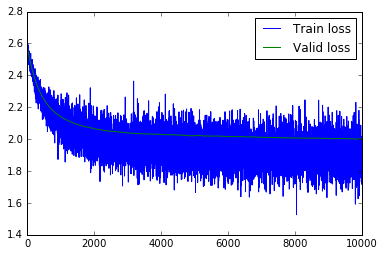

In [43]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

In [44]:
loss_train = np.array(nn.losses['train'], dtype=float)
loss_valid = np.array(nn.losses['valid'], dtype=float)
loss_train.shape, loss_valid.shape

((10000,), (10000,))

In [45]:
loss_train_norm = (loss_train - loss_train.mean(axis=0))/ loss_train.std(axis=0)
loss_valid_norm = (loss_valid - loss_valid.mean(axis=0))/ loss_valid.std(axis=0)

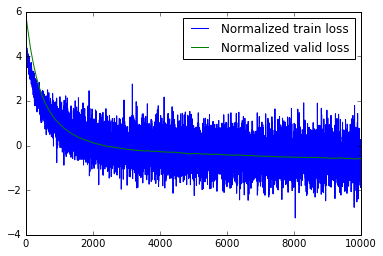

In [46]:
plt.plot(loss_train_norm, label='Normalized train loss')
plt.plot(loss_valid_norm, label='Normalized valid loss')
plt.legend()
plt.show()

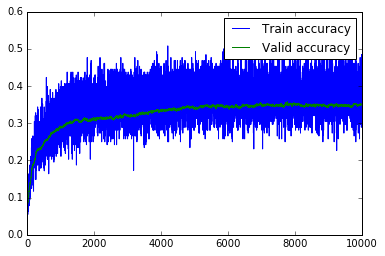

In [47]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()

In [48]:
heading = labels_keys_sorted.copy()
heading.insert(0, 'Id')
heading

['Id',
 'Blues',
 'Country',
 'Electronic',
 'Folk',
 'International',
 'Jazz',
 'Latin',
 'New_Age',
 'Pop_Rock',
 'Rap',
 'Reggae',
 'RnB',
 'Vocal']

In [49]:
y_pred, y_logits = nn.test(X_test)
y_prob = softmax(y_logits)
y_prob.shape, X_test.shape, y_logits.shape, test_y_sample.shape, test_y_sample[:1]

((10400, 13),
 (10400, 26),
 (10400, 13),
 (10400, 14),
    Id   Blues  Country  Electronic    Folk  International    Jazz   Latin  \
 0   1  0.0964   0.0884      0.0121  0.1004         0.0137  0.1214  0.0883   
 
    New_Age  Pop_Rock     Rap  Reggae     RnB   Vocal  
 0   0.0765    0.0332  0.0445  0.1193  0.1019  0.1038  )

In [50]:
pred_list = []
for Id, pred in enumerate(y_prob):
#     print(Id+1, *pred)
    pred_list.append([Id+1, *pred])

In [51]:
pred_file = open(file='prediction.csv', mode='w')
pred_file.write('\n') # because of the previous line        

for idx in range(len(heading)):
    if idx < len(heading) - 1:
        pred_file.write(heading[idx] + ',')
    else:
        pred_file.write(heading[idx] + '\n')        

# len(test), test[0]
# for key in test:
for i in range(len(pred_list)): # rows
    for j in range(len(pred_list[i])): # cols
        if j < (len(pred_list[i]) - 1):
            pred_file.write(str(pred_list[i][j]))
            pred_file.write(',')
        else: # last item before starting a new line
            pred_file.write(str(pred_list[i][j]) + '\n')        

# pred_file.write(-',')
pred_file.close()

In [52]:
pd.read_csv(filepath_or_buffer='prediction.csv').head()

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.021750,0.011936,0.023063,0.005865,0.018174,0.026812,0.038575,0.001421,0.002437,0.429212,0.331227,0.069911,0.019619
1,2,0.034147,0.022955,0.017848,0.019824,0.038241,0.003981,0.089666,0.001520,0.006741,0.208897,0.456143,0.053426,0.046612
2,3,0.011121,0.013971,0.038408,0.009404,0.028614,0.002384,0.030563,0.000922,0.043283,0.200926,0.540178,0.071665,0.008561
3,4,0.049389,0.035180,0.074036,0.033026,0.029846,0.009964,0.024531,0.005178,0.012154,0.053119,0.480933,0.072064,0.120579
4,5,0.020836,0.007829,0.014097,0.002612,0.006678,0.000345,0.011924,0.000117,0.013499,0.536314,0.369531,0.013556,0.002662


In [53]:
pd.read_csv(filepath_or_buffer='prediction.csv').shape, test_y_sample.shape

((10400, 14), (10400, 14))

In [54]:
test_y_sample.head()

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.0964,0.0884,0.0121,0.1004,0.0137,0.1214,0.0883,0.0765,0.0332,0.0445,0.1193,0.1019,0.1038
1,2,0.0121,0.0804,0.0376,0.0289,0.1310,0.0684,0.1044,0.0118,0.1562,0.0585,0.1633,0.1400,0.0073
2,3,0.1291,0.0985,0.0691,0.0356,0.0788,0.0529,0.1185,0.1057,0.1041,0.0075,0.0481,0.1283,0.0238
3,4,0.0453,0.1234,0.0931,0.0126,0.1224,0.0627,0.0269,0.0764,0.0812,0.1337,0.0357,0.0937,0.0930
4,5,0.0600,0.0915,0.0667,0.0947,0.0509,0.0335,0.1251,0.0202,0.1012,0.0365,0.1310,0.0898,0.0991
